# Emissions Analysis

## Data Analysis: Student Survey

In [1]:
# Standard imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Load cleaned student survey information
student_survey = pd.read_csv(
    "../data/csv/student/student_survey_cleaned_v1.csv"
)
student_survey["BMG_ID"] = student_survey["BMG_ID"].astype("string")
student_survey.rename(columns={"BMG_ID": "bmg_id"}, inplace=True)

In [3]:
print(student_survey.info())
print(student_survey.describe())
print(student_survey.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bmg_id                   565 non-null    string 
 1   Occupancy                565 non-null    float64
 2   Household Ownership      561 non-null    object 
 3   Landlord Type            565 non-null    object 
 4   Green Energy             561 non-null    object 
 5   Eco Type                 561 non-null    object 
 6   Gas Supply               561 non-null    object 
 7   Smart Meter              561 non-null    object 
 8   Meter Reading Frequency  560 non-null    object 
 9   Primary Heating          560 non-null    object 
 10  EV                       552 non-null    object 
 11  Property Type            551 non-null    object 
 12  Number of bedrooms       550 non-null    float64
 13  Main Heating System      560 non-null    object 
 14  Water Heating System     5

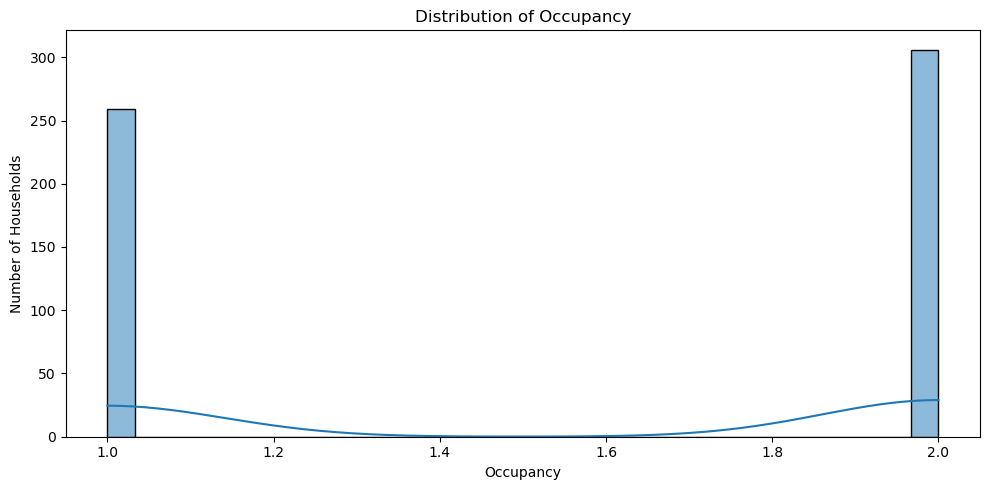

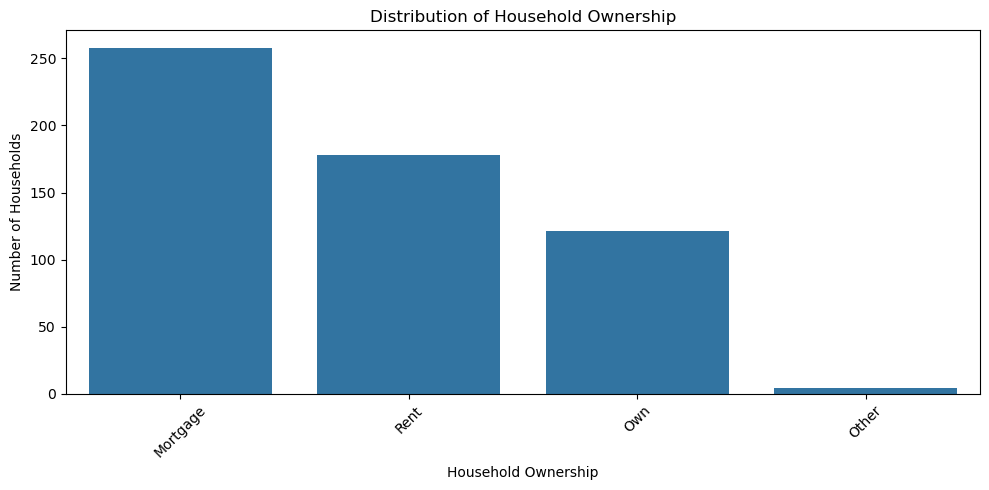

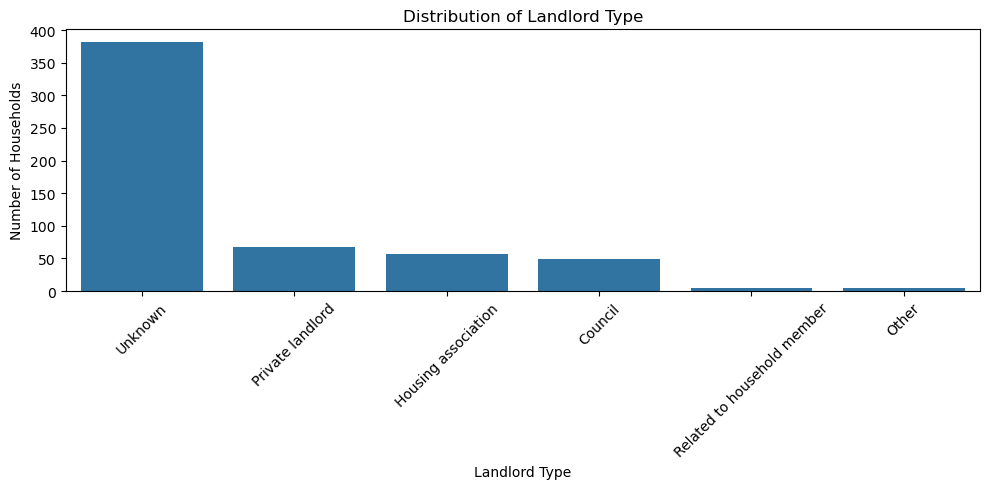

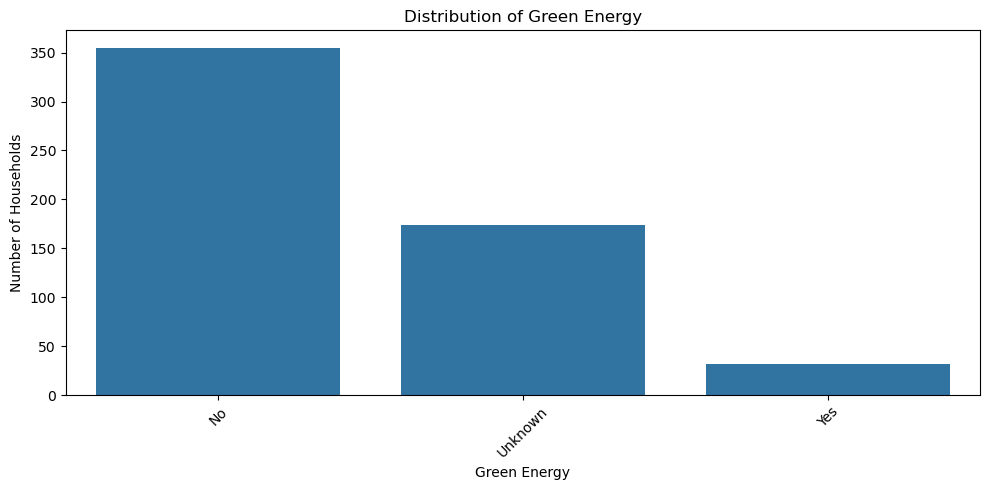

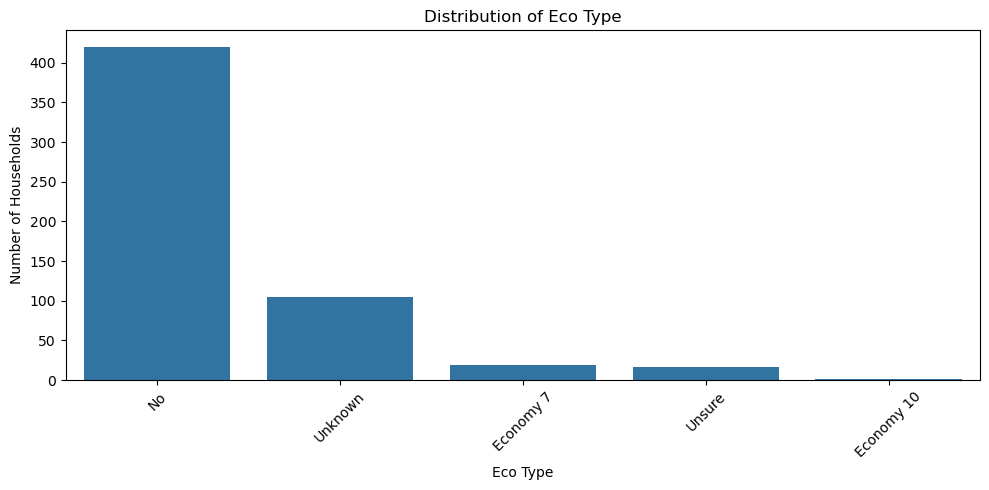

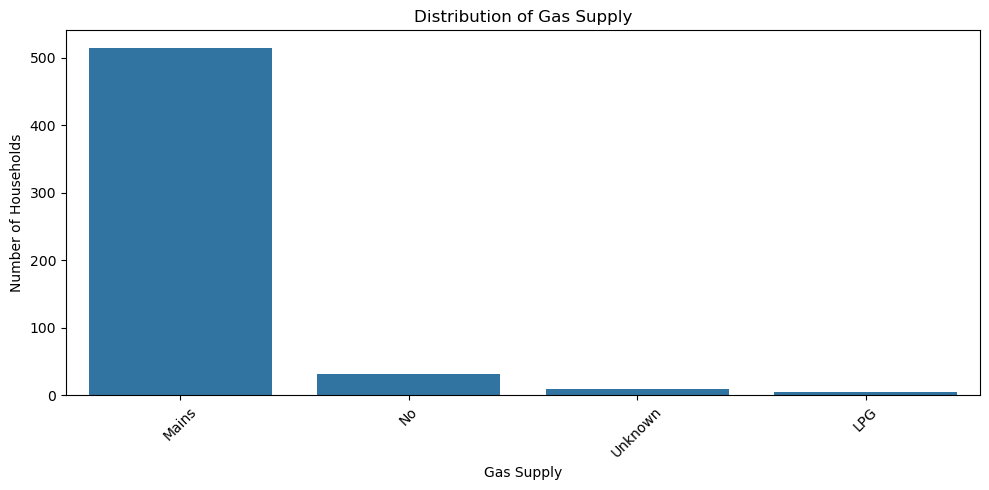

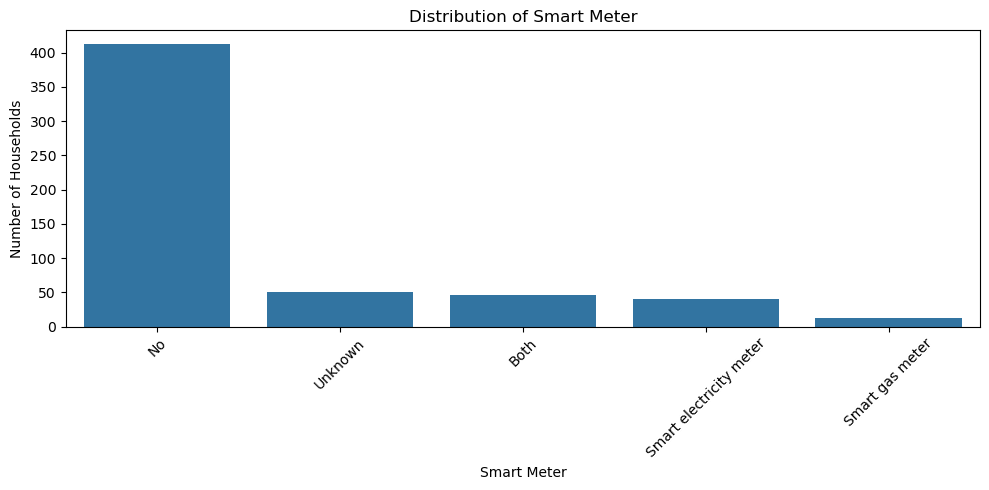

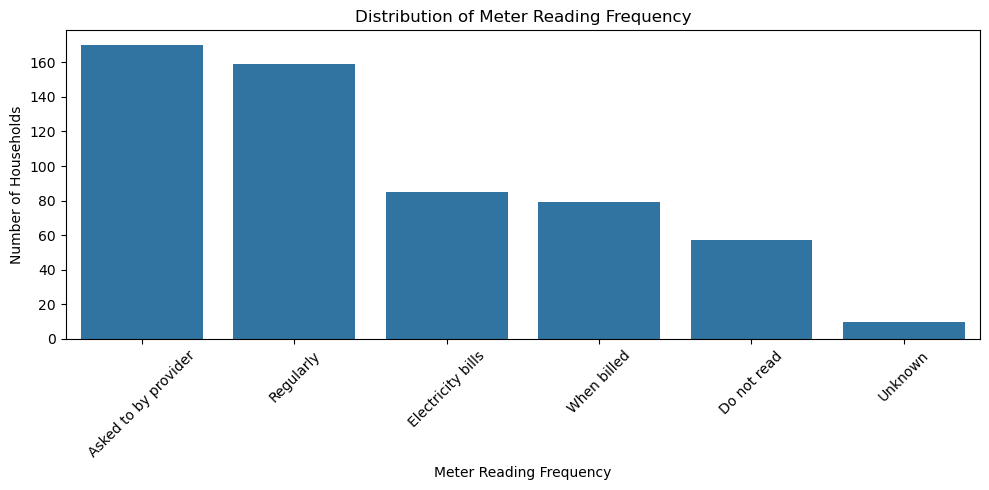

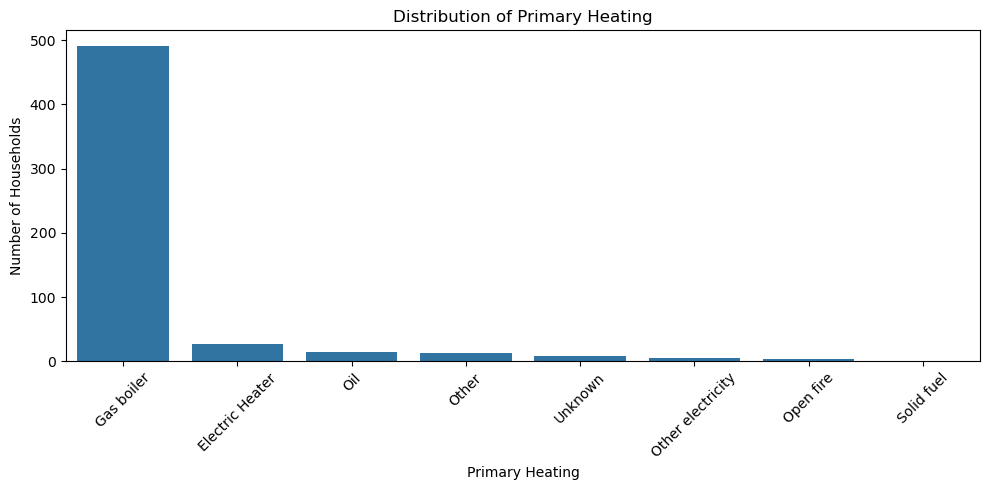

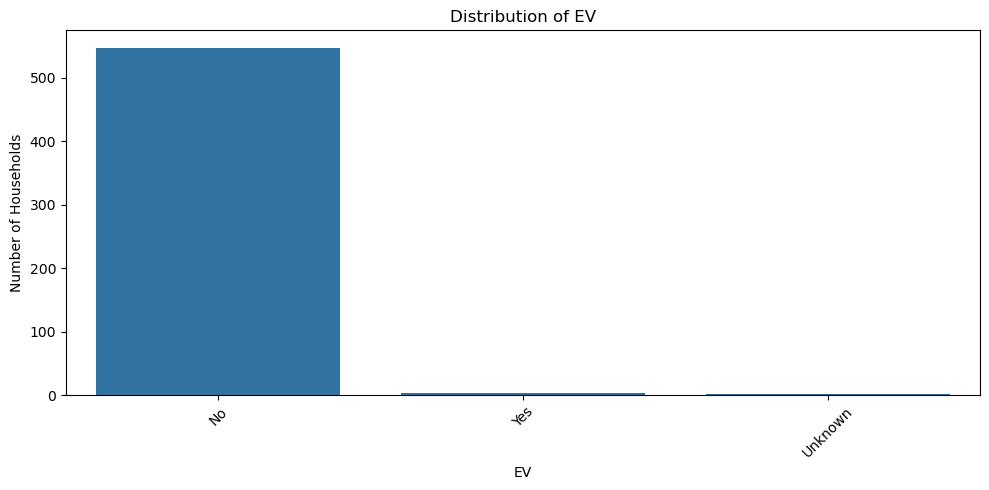

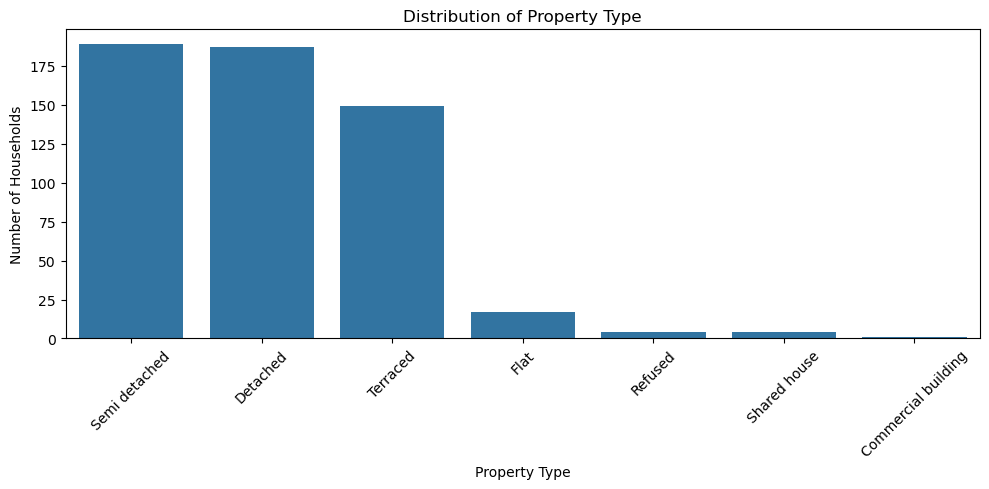

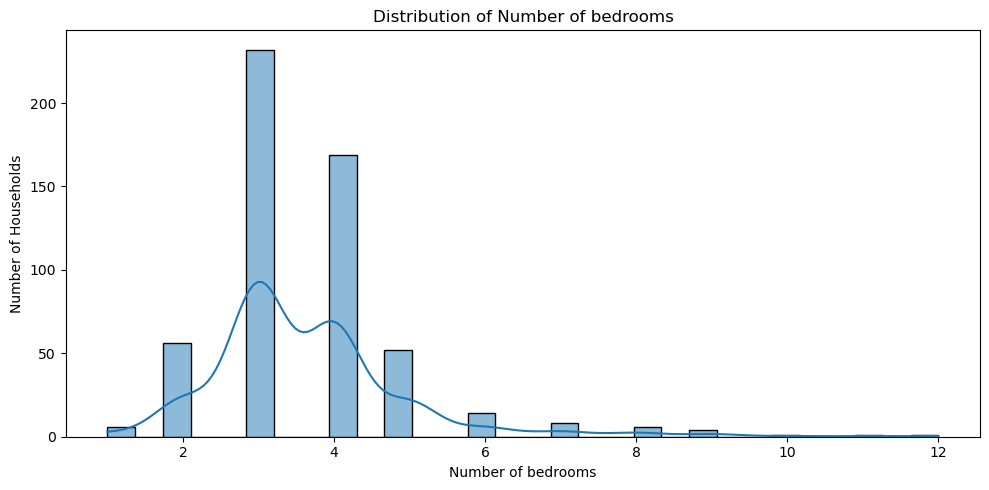

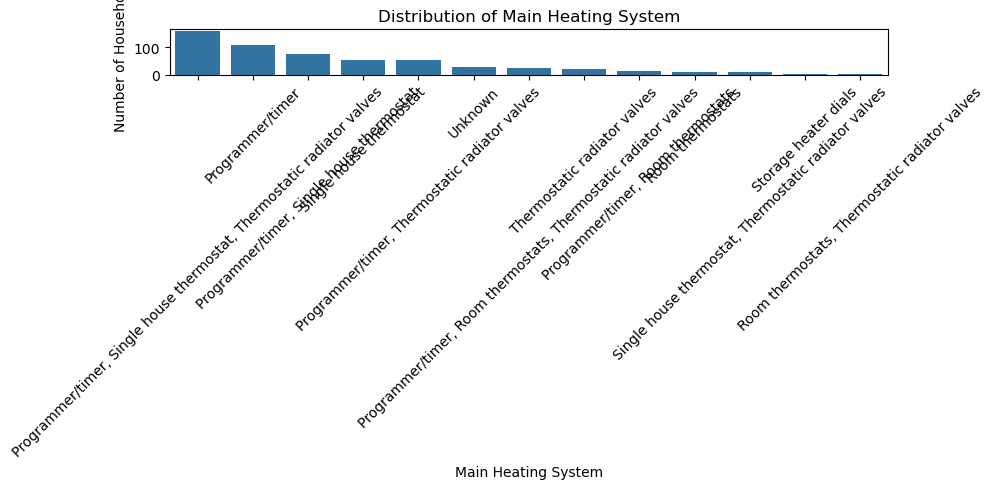

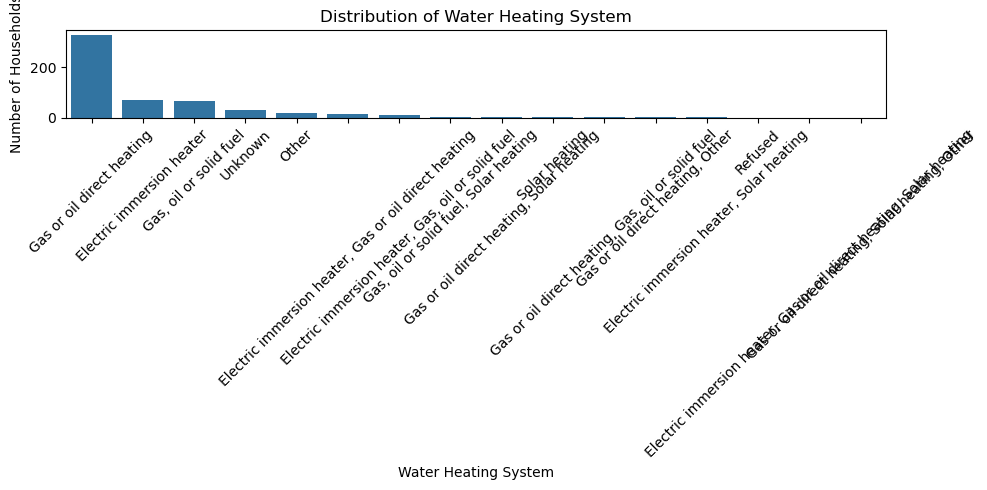

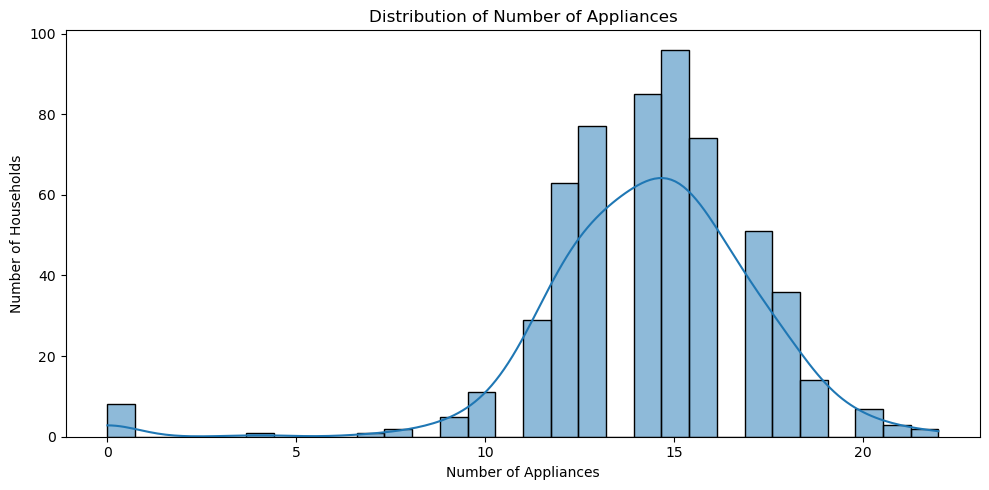

In [4]:
# Understand the distribution of household data across the survey categories
for col in student_survey.columns:
    if col == "bmg_id" or col == "Appliances":
        continue
    plt.figure(figsize=(10, 5))

    if student_survey[col].dtype == "object":
        sns.countplot(
            data=student_survey,
            x=col,
            order=student_survey[col].value_counts().index,
        )
        plt.xticks(rotation=45)
    else:
        sns.histplot(student_survey[col], bins=30, kde=True)

    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Number of Households")
    plt.tight_layout()
    plt.show()

## Data Analysis: CO2 Emissions

### BEIS Median Emission 2023

In [5]:
me = pd.read_excel(
    "../data/csv/emissions/co2emissionsenglandandwales.xlsx",
    sheet_name=["1b", "1c"],
    skiprows=3,
)

# Isolate only England
me_property_type = me.get("1b")
me_property_type = me_property_type[
    me_property_type["Country or region name"] == "England"
]
me_tenure = me.get("1c")
me_tenure = me_tenure[me_tenure["Country or region name"] == "England"]

print(me_property_type.T)
print(me_tenure.T)

                                0
Country or region code  E92000001
Country or region name    England
Detached                      4.3
Semi-detached                 3.5
Terraced                      3.3
Flats and maisonettes         1.9
                                0
Country or region code  E92000001
Country or region name    England
Owner occupied                3.8
Private rent                  3.0
Social rent                   2.4


## BEIS Energy Effeciency

In [6]:
ee = pd.read_excel(
    "../data/csv/emissions/medianenergyefficiencyscoreenglandandwales.xlsx",
    sheet_name=["1b", "1c"],
    skiprows=3,
)

# Isolate only England
ee_property_type = ee.get("1b")
ee_property_type = ee_property_type[
    ee_property_type["Country or region name"] == "England"
]
ee_tenure = ee.get("1c")
ee_tenure = ee_tenure[ee_tenure["Country or region name"] == "England"]

print(ee_property_type.T)
print(ee_tenure.T)

                                0
Country or region code  E92000001
Country or region name    England
Detached                       67
Semi-detached                  66
Terraced                       67
Flats and maisonettes          73
                                0
Country or region code  E92000001
Country or region name    England
Owner-occupied                 65
Private rent                   67
Social rent                    70


In [7]:
ee = pd.read_excel(
    "../data/csv/emissions/medianenergyefficiencycountrytolocalauthority.xlsx",
    sheet_name=["3", "5"],
    skiprows=2,
)

# Isolate only England
ee_heating_type = ee.get("3")
ee_heating_type = ee_heating_type[
    ee_heating_type["Area name"] == "England"
].reset_index(drop=True)
ee_occupancy = ee.get("5")
ee_occupancy = ee_occupancy[
    ee_occupancy["Area name"] == "England"
].reset_index(drop=True)

print(ee_heating_type)
print(ee_occupancy)

    Area code Area name                               Central Heating Type  \
0   E92000001   England                                 No central heating   
1   E92000001   England                                     Mains gas only   
2   E92000001   England                           Tank or bottled gas only   
3   E92000001   England          Electric (including storage heaters) only   
4   E92000001   England                                           Oil only   
5   E92000001   England  Wood (for example, logs, waste wood or pellets...   
6   E92000001   England                   Solid fuel (including coal) only   
7   E92000001   England  Renewable energy (for example, solar thermal o...   
8   E92000001   England            District or communal heat networks only   
9   E92000001   England                         Other central heating only   
10  E92000001   England  Two or more types of central heating (not incl...   
11  E92000001   England  Two or more types of central heating (i

### Mapping Energy Efficiency Values to Survey Data

We have four main indicators that will be used to compute the total energy efficiency score:
- Property type
- Tenure
- Central heating type
- Household size

In [8]:
# Generate a dictionary for each factor
property_map = ee_property_type.drop(
    ["Country or region code", "Country or region name"], axis=1
).to_dict("records")[0]
tenure_map = ee_tenure.drop(
    ["Country or region code", "Country or region name"], axis=1
).to_dict("records")[0]
heating_map = dict(
    zip(
        ee_heating_type["Central Heating Type"],
        ee_heating_type["Median Energy Efficiency score"],
    )
)
occupancy_map = dict(
    zip(
        ee_occupancy["Household size"].str[0],
        ee_occupancy["Median Energy Efficiency score"],
    )
)


def calc_effeciency(df):
    ee = 0

    match df["Household Ownership"]:
        case "Mortgage" | "Own":
            ee += tenure_map.get("Owner-occupied", 0)
        case "Rent":
            ee += tenure_map.get("Private rent", 0)
        case "Other":
            ee += tenure_map.get("Social rent", 0)

    match df["Property Type"]:
        case "Detached":
            ee += property_map.get("Detached", 0)
        case "Semi detached":
            ee += property_map.get("Semi-detached", 0)
        case "Terraced":
            ee += property_map.get("Terraced", 0)
        case "Flat" | "Commercial building":
            ee += property_map.get("Flats and maisonettes", 0)
        case _:
            ee += 50

    match df["Primary Heating"]:
        case "Gas boiler":
            ee += heating_map.get("Mains gas only", 0)
        case "Other electricity" | "Electric Heater":
            ee += heating_map.get(
                "Electric (including storage heaters) only", 0
            )
        case "Oil":
            ee += heating_map.get("Oil only", 0)
        case "Open fire":
            ee += heating_map.get(
                "Wood (for example, logs, waste wood or pellets) only", 0
            )
        case "Other":
            ee += heating_map.get("Other central heating only", 0)
        case "Solid fuel":
            ee += heating_map.get("Solid fuel (including coal) only", 0)
        case "Unknown":
            ee += 50
        case _:
            ee += heating_map.get("No central heating", 0)

    bedrooms = df["Occupancy"]
    if pd.notna(bedrooms):
        occupancy_key = str(int(bedrooms)) if int(bedrooms) < 5 else "4"
        ee += occupancy_map.get(occupancy_key, 0)
    else:
        ee += 0

    return (ee * 0.25) / 100

## Energy Usage kWh to Carbon Emission Conversion

Based on the GHG reports from the UK Government (BEIS) 

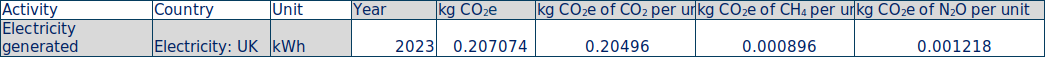

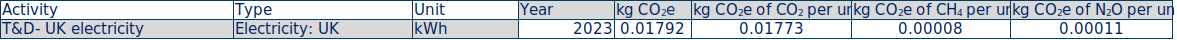

In [9]:
df = pd.read_excel(
    "../data/csv/emissions/ghg-conversion-factors-2023-condensed-set-update.xlsx",
    sheet_name="UK electricity",
    skiprows=22,
    nrows=2,
)

df_1 = pd.read_excel(
    "../data/csv/emissions/ghg-conversion-factors-2023-condensed-set-update.xlsx",
    sheet_name="Transmission and distribution",
    skiprows=19,
    nrows=2,
)

conversion_factor_df = pd.concat([df, df_1], axis=0).reset_index(drop=True)
conversion_factor_df = conversion_factor_df.drop(["Country", "Type"], axis=1)

ghg_conversion_factor = conversion_factor_df.sum()["kg CO2e"]
print(ghg_conversion_factor)

0.2249894


## Emission Calculation and Forecasting

### All students

               energy  emissions
ds                              
2017-01-01  14.770727   3.323257
2017-01-02  12.879095   2.897660
2017-01-03  11.925015   2.683002
2017-01-04  12.227516   2.751061
2017-01-05  12.009058   2.701911


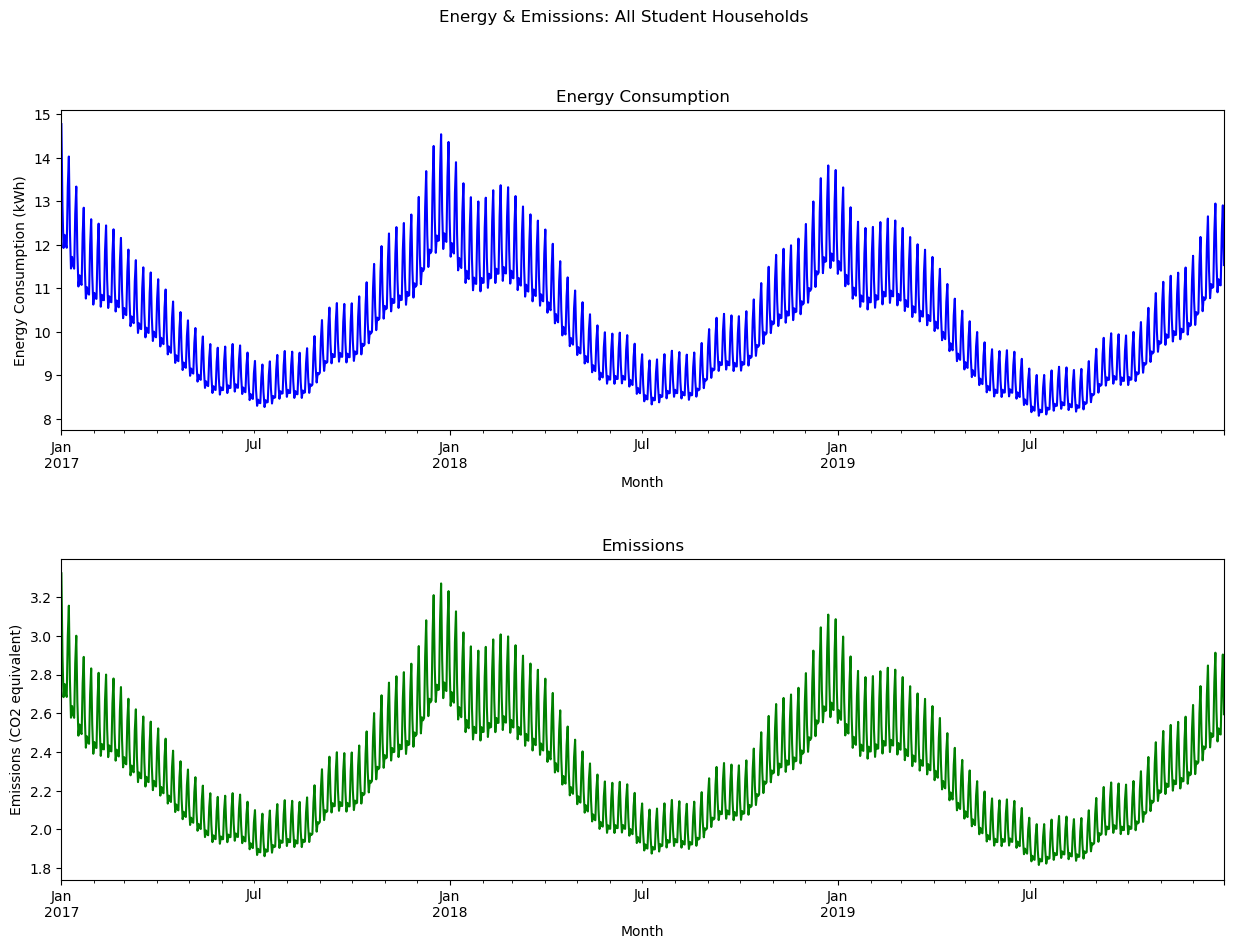

Median emission across all households: 2.247188474831307


In [10]:
median_energy_consumption = pd.read_csv(
    "../models/results/median_forecast.csv",
    usecols=["ds", "yhat"],
)
median_energy_consumption["ds"] = pd.to_datetime(
    median_energy_consumption["ds"]
)
median_energy_consumption = median_energy_consumption.rename(
    {"yhat": "energy"}, axis=1
)
median_energy_consumption["emissions"] = (
    median_energy_consumption["energy"] * ghg_conversion_factor
)

median_energy_consumption = median_energy_consumption.set_index('ds')

print(median_energy_consumption.head())

# Visualise both the energy use and the emissions
fig, ax = plt.subplots(nrows=2, figsize=(15, 10))
fig.suptitle("Energy & Emissions: All Student Households")
plt.subplots_adjust(hspace=0.4)
median_energy_consumption["energy"].plot(ax=ax[0], color="blue")
ax[0].set_ylabel("Energy Consumption (kWh)")
ax[0].set_xlabel("Month")
ax[0].set_title("Energy Consumption")
median_energy_consumption["emissions"].plot(ax=ax[1], color="green")
ax[1].set_ylabel("Emissions (CO2 equivalent)")
ax[1].set_xlabel("Month")
ax[1].set_title("Emissions")
plt.show()

print(f"Median emission across all households: {median_energy_consumption['emissions'].median()}")

median_energy_consumption.to_csv("../data/csv/student/median_emissions.csv")

### Single Student Sample

In [11]:
energy_consumption = pd.read_csv(
    "../models/results/sample_A2956626330_forecast_with_reg.csv",
    usecols=["ds", "yhat"],
)
energy_consumption["ds"] = pd.to_datetime(energy_consumption["ds"])
energy_consumption = energy_consumption.set_index("ds")
row = student_survey[student_survey["bmg_id"] == "956626330"]
if row.empty:
    raise ValueError("No matching bmg_id found in student_survey for '956626330'")
emission_factor = ghg_conversion_factor * (1 / calc_effeciency(row.iloc[0]))
energy_consumption["emissions"] = energy_consumption['yhat'] * ghg_conversion_factor
energy_consumption["corrected_emissions"] = energy_consumption['yhat'] * emission_factor
energy_consumption = energy_consumption.rename({'yhat': 'energy'}, axis=1)

print(f"Effeciency rating: {calc_effeciency(row.iloc[0]) * 100}")
print(f"Raw emission factor: {ghg_conversion_factor}")
print(f"Corrected emission factor: {emission_factor}")

energy_consumption['efficiency_rating'] = calc_effeciency(row.iloc[0]) * 100
energy_consumption['emissions_factor'] = ghg_conversion_factor
energy_consumption['corrected_emissions_factor'] = emission_factor

energy_consumption.to_csv('../data/csv/student/956626330_emissions.csv')

Effeciency rating: 66.25
Raw emission factor: 0.2249894
Corrected emission factor: 0.339606641509434


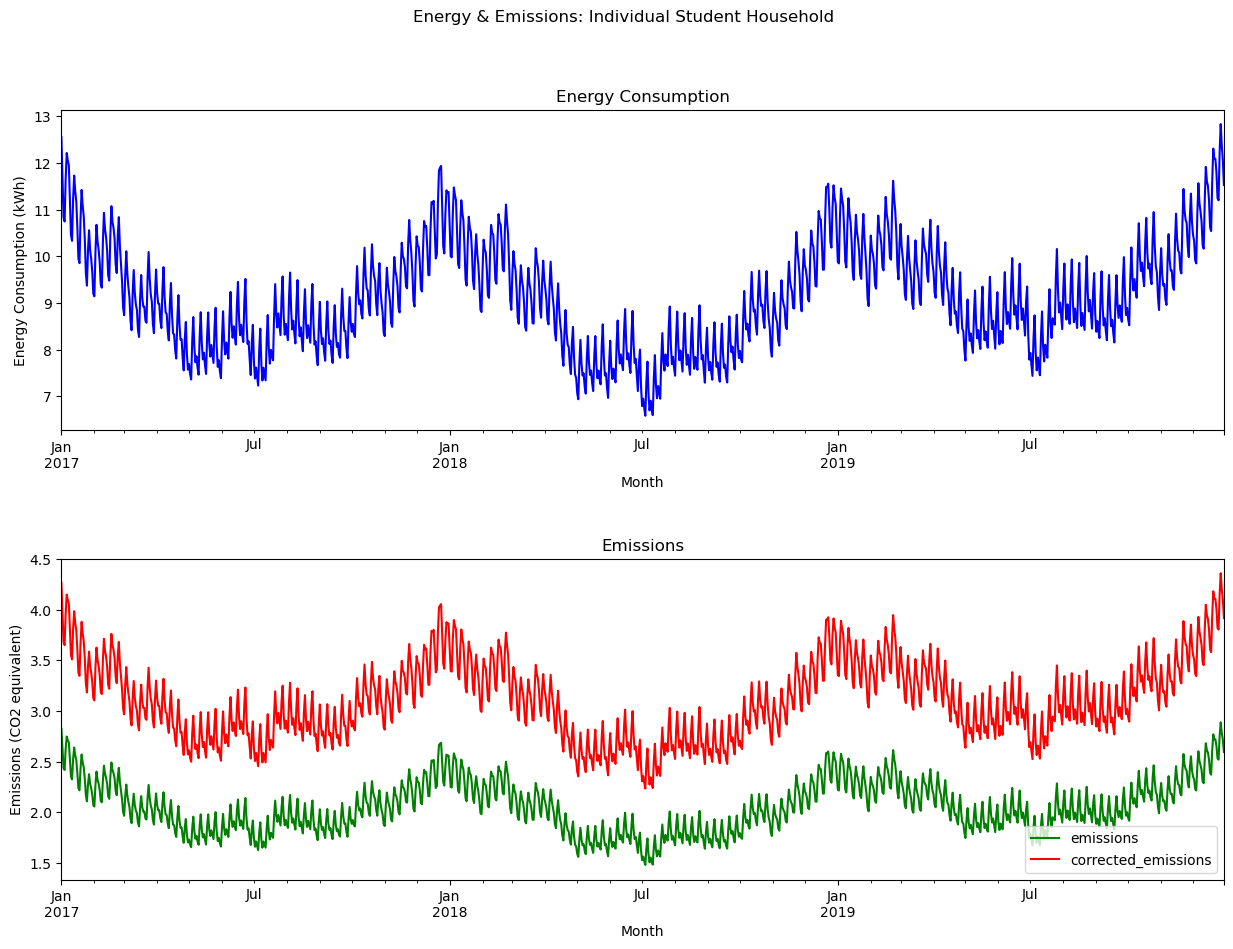

In [12]:
# Visualise both the energy use and the emissions
fig, ax = plt.subplots(nrows=2, figsize=(15, 10))
fig.suptitle("Energy & Emissions: Individual Student Household")
plt.subplots_adjust(hspace=0.4)
energy_consumption['energy'].plot(ax=ax[0], color='blue')
ax[0].set_ylabel("Energy Consumption (kWh)")
ax[0].set_xlabel("Month")
ax[0].set_title("Energy Consumption")
energy_consumption['emissions'].plot(ax=ax[1], color='green')
energy_consumption['corrected_emissions'].plot(ax=ax[1], color='red')
ax[1].set_ylabel("Emissions (CO2 equivalent)")
ax[1].set_xlabel("Month")
ax[1].set_title("Emissions")
ax[1].legend(loc="lower right")

plt.show()